# DICOM to NIFTI Conversion

In [10]:
import pydicom
import numpy as np
import matplotlib.pyplot as plt
import os

In [111]:
folder = "../0_data/05/2017-12-20"
_, _, files = next(os.walk(folder))
files

#GE Scanners
GE_b = 0x0043,0x1039

# Get ref file
RefDs = pydicom.dcmread(f"{folder}/{files[0]}")

# Load spacing values (in mm)
ConstPixelSpacing = (float(RefDs.PixelSpacing[0]), float(RefDs.PixelSpacing[1]), float(RefDs.SliceThickness))

#read DICOMs and calculate how many b values exist
b_vals = []
for i in range(len(files)):
    ds = pydicom.dcmread(f"{folder}/{files[i]}")
    b_val = ds[GE_b].repval.split("\\\\")[0]
    if b_val not in b_vals:
        b_vals.append(b_val)
    
#Create an np array for each b value
num_dcm = int(len(files)/len(b_vals))

# Load dimensions based on the number of rows, columns, and slices*b_vals (along the Z axis)
ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns), len(files))

#The array is sized based on 'ConstPixelDims'
ArrayDicom = np.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)

for filename in files:
    ds = pydicom.dcmread(f"{folder}/{filename}")
    ArrayDicom[:,:,files.index(filename)] = ds.pixel_array

#Seperate into each bvalue array
bArray = {}
for i in range(len(b_vals)):
    bArray[b_vals[i].split("'")[1]] = ArrayDicom[:,:,num_dcm*i:num_dcm*(i+1)]

In [145]:
#Calculate ADC map
def fit_exp_linear(t, y, C=0):
    y = np.array(y) - C
    y = np.log(y)
    K, A_log = np.polyfit(t, y, 1)
    A = np.exp(A_log)
    return A, K

def model_func(t, A, K, C):
    return A * np.exp(K * t) + C

def calc_adc(b_dict):
    linArray = []
    for k,v in b_dict.items():
        dims = b_dict[k].shape
        if k != "0":
            b = str(int(k[-1:]))
        else:
            b = "0"
            
        linArray.append((b,b_dict[k].ravel()))
    
    length = dims[0]*dims[1]*dims[2]
    linADC = []
    for j in range(length):
        _, ADC = fit_exp_linear([i[0] for i in linArray], [i[1][j] for i in lst])
        linADC.append(ADC)
    return linADC.reshape(dims)

calc_adc(bArray)

TypeError: 'int' object is not subscriptable

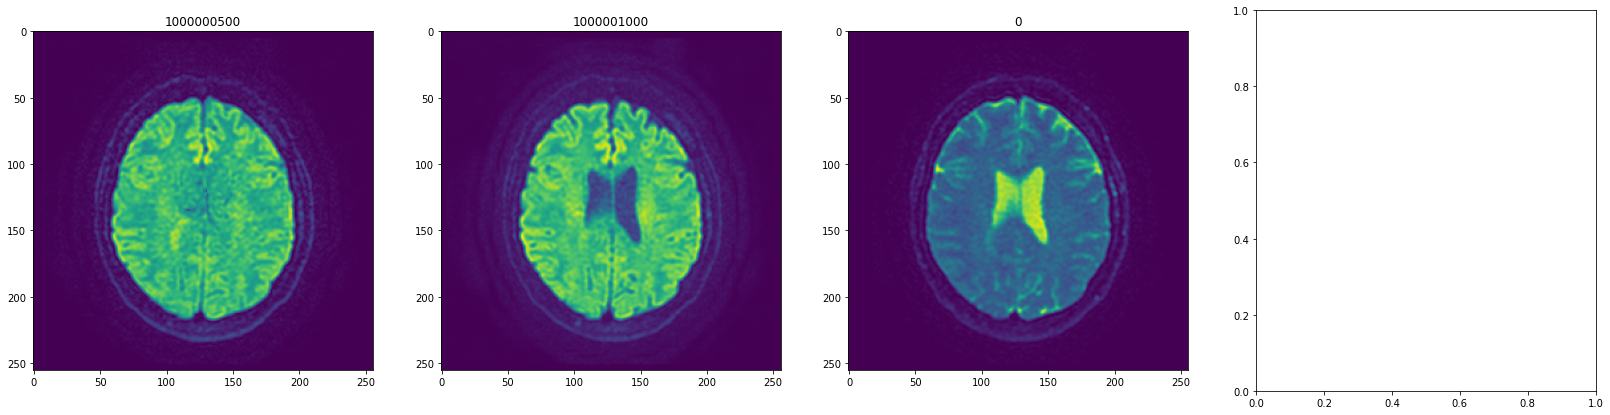

In [109]:
fig, ax = plt.subplots(1,4,figsize=(28,7))

for i, (k,v) in enumerate(bArray.items()):
    ax[i].imshow(v[:,:,30])
    ax[i].set_title(str(k))
    

In [126]:
bArray['0'].shape[0]

256

In [127]:
lst = [(0,[1,2,3]),
      (1,[4,5,6]),
      (2,[7,8,9]),]

In [140]:
[i[1][2] for i in lst]

[3, 6, 9]

In [143]:
lst = [1,2,3]

In [144]:
lst-2

TypeError: unsupported operand type(s) for -: 'list' and 'int'